# Preprocessing
### Imports

New Python versions sometimes require some extra installations found in the code below

In [1]:
!pip install standard-sunau standard-aifc


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch.utils.data import DataLoader, Dataset
# Utils
import numpy as np
from numpy import ndarray
import logging
# Base Scripts
from Libraries.Utils import *
from Conf import conf


c:\Users\finia\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [4]:
remote_kernel: bool = False
training_data_name: str = "training_maestro_mel"
n_samples: int = 10000
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)
filenames_wav = get_filenames_from_folder(path_to_remote_path(conf["paths"].data_path, remote_kernel), "wav")
filenames_midi = get_filenames_from_folder(path_to_remote_path("../Data/maestro-v3/2018", remote_kernel), "midi")

2025-06-30 15:28:04,549 - LIGHT_DEBUG - Got filenames ['Am Bach 2024.wav', 'Cutting Mixes mix.wav', 'DA2407_ADO.wav'] from ../Data
2025-06-30 15:28:04,579 - LIGHT_DEBUG - Got filenames ['MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--2.midi', 'MIDI-Unprocessed_Chamber4_MID--AUDIO_11_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber5_MID--AUDIO_18_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--2.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--3.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--4.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--1.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_20

### Processing .mid

In [ ]:
data: list = []

for i in range(len(filenames_midi)):
    data.append(midi2ndarray("../Data/maestro-v3/2018/{}".format(filenames_midi[i]), sr=32000, sf_path="../Libraries/UprightPiano.sf2"))
    print(data.shape)

### Processing .wav

In [ ]:
data: list = []
remaining_samples: int = n_samples
for i in range(len(filenames_wav)):
    file = load_audio_file(os.path.join(path_to_remote_path(conf["paths"].data_path, remote_kernel), filenames_wav[i]), 24000, True)
    file = split_audiofile(file, 5.4614, 24000, 0)[:, :2**17]
    file = audio_splits_to_mel_spectrograms(file, 1023, 256, 24000, True, 30, 96)
    data.append(file)
    if file.shape[0] < remaining_samples:
        remaining_samples -= file.shape[0]
    else: break

data: ndarray = np.vstack(data)
data = normalize_filewise(data, -1, 1)
#data = dimension_for_VAE(data)[:n_samples]
logger.info(f"Processed data of shape: {data.shape}")

### Saving

In [ ]:
save_training_data(data, f"{path_to_remote_path(conf["paths"].data_path, remote_kernel)}/{training_data_name}.npy")

### Test Blocks

In [ ]:
print(np.min(data), np.max(data))

In [ ]:
file = load_audio_file(os.path.join(path_to_remote_path(conf["paths"].data_path, remote_kernel), filenames_wav[0]), 32000, True)
file = split_audiofile(file, 4.096, 32000, 0)



In [ ]:
rnd = np.random.randn(1846, 131072)
mae = np.sum(np.abs(file - normalize(rnd))) / 1846
print(mae)

In [ ]:
import torch

from vocos import Vocos

mel = torch.tensor(normalize(audio_to_mel_spectrogram(file[70], 1023, 256, 24000, True, min_freq=30, n_mels=100))[:, :256]).unsqueeze(0)

vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")

audio = vocos.decode(mel)

In [ ]:
save_audio_file(librosa.feature.inverse.mel_to_audio(normalize(audio_to_mel_spectrogram(file[70], 1023, 256, 24000, True, min_freq=30, n_mels=100)), sr=24000,n_fft=1023, hop_length=256), "gl_reconstructed.wav", 24000)

In [ ]:
print(normalize(audio_to_mel_spectrogram(file[70], 1023, 256, 24000, True, min_freq=30, n_mels=100)).shape)
plt.title("Mel spectrogram")
plt.xlabel("Time")
plt.xlim(0, 512)
plt.ylabel("Mel bins")
plt.imshow(normalize(audio_to_mel_spectrogram(file[70], 1023, 256, 32000, True, min_freq=30, n_mels=96)), origin="lower", cmap="PuBu")
plt.show()
"""
spec = audio_to_mel_spectrogram(file[70], 2048, 256, 32000, True, min_freq=30, n_mels=128)
spec = normalize(spec, -1, 1)
plt.imshow(spec, cmap = "PuRd", origin="lower")
"""
#save_audio_file(spectrogram_to_audio(spec, 480, 288, conf["audio"].sr), "../Results/low_res.wav", sr=conf["audio"].sr

In [6]:
training_data_name: str = "training_maestro_mel"
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))

2025-06-30 15:29:01,998 - LIGHT_DEBUG - Ndarray loaded from ../Data/training_maestro_mel.npy of shape: (5000, 96, 512)


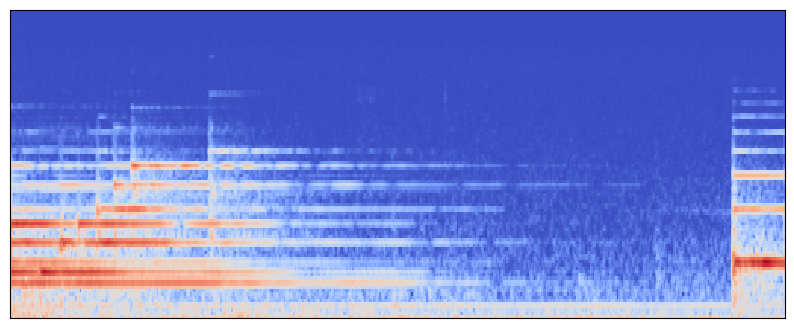

In [13]:
visualize_spectrogram(file[789], 32000, 1024)